In [1]:
import cv2                
import numpy as np         
import os                  
from random import shuffle 
from tqdm import tqdm
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import matplotlib.pyplot as plt
import dicom

In [2]:
TRAIN_DIR = '/home/aayushi/meddiff/train-med/train'
TEST_DIR = '/home/aayushi/meddiff/train-med/test'
IMG_SIZE = 50
LR = 0.001
MODEL_NAME = 'ct-{}-{}.model'.format(LR, '4conv-basic')

def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array
    if word_label == 'lymph': return [1,0,0]
    elif word_label == 'colon': return [0,1,0]
    elif word_label == 'brain' : return [0,0,1]
    
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = dicom.read_file(path, force=True)
        new_img = cv2.resize(np.array(img.pixel_array),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(new_img),np.array(label)])
    shuffle(training_data)
    np.save('/home/aayushi/meddiff/train-med/train.npy', training_data)
    return training_data   

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = dicom.read_file(path, force=True)
        new_img = cv2.resize(np.array(img.pixel_array),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(new_img), img_num])
        
    shuffle(testing_data)
    np.save('/home/aayushi/meddiff/train-med/test.npy', testing_data)
    return testing_data

train_data = create_train_data()


100%|██████████| 2844/2844 [00:03<00:00, 745.91it/s]


In [3]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 3, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
    
train = train_data[:-150]
test = train_data[-150:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=100, show_metric=True, run_id=MODEL_NAME)

Training Step: 429  | total loss: 0.00000 | time: 5.275s
| Adam | epoch: 010 | loss: 0.00000 - acc: 1.0000 -- iter: 2688/2694
Training Step: 430  | total loss: 0.00000 | time: 6.379s
| Adam | epoch: 010 | loss: 0.00000 - acc: 1.0000 | val_loss: 0.00000 - val_acc: 1.0000 -- iter: 2694/2694
--


100%|██████████| 24/24 [00:00<00:00, 505.98it/s]


Arg max: 1
Image number= 1
Probabilities: [  4.35887390e-15   1.00000000e+00   5.07741689e-13]
Arg max: 2
Image number= 17
Probabilities: [  3.92572031e-15   6.98095892e-14   1.00000000e+00]
Arg max: 1
Image number= 9
Probabilities: [  5.24998644e-16   1.00000000e+00   6.04065206e-14]
Arg max: 2
Image number= 18
Probabilities: [  2.01747680e-14   3.21627978e-13   1.00000000e+00]
Arg max: 0
Image number= 13
Probabilities: [  1.00000000e+00   1.17927959e-11   2.85762886e-10]
Arg max: 0
Image number= 14
Probabilities: [  1.00000000e+00   2.00064119e-12   5.45808433e-11]


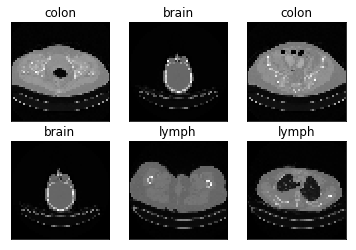

In [7]:
#if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num  ,data in enumerate(test_data[:6]):
  
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(2,3,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    print('Arg max:', np.argmax(model_out))
    print('Image number=', img_num)
    if np.argmax(model_out) == 2: str_label='brain'
    elif np.argmax(model_out) == 1: str_label='colon'
    else: str_label='lymph'
    print('Probabilities:', model_out)   
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()